# In it for the Win: Jeopardy Questions

## Table of Contents

* [Introduction](#intorduction)
* [Goal](#goal)
* [Summary](#summary)
* [The Data](#the_data)
* [Cleaning the Data](#cleaning_the_data) 
  * [Cleaning Column Names](#cleaning_column_names) 
  * [Removing Null Values](#removing_null_values)
  * [Normalizing Text](#normalizing_text)
  * [Normalizing Columns](#normalizing_columns)
* [Analysis](#analysis)
  * [Answers in Questions](#answers_in_questions)
  * [Recycled Questions](#recycled_questions)
  * [Low Value vs. High Value Questions](#low_v_high_value_questions)
* [Conclusion](#conclusion)
* [Next Steps](#next_steps)

## Introduction  <a name="introduction"></a>

[Jeopardy](https://en.wikipedia.org/wiki/Jeopardy!#Gameplay) is a popular TV show in the US where participants answer trivia questions to win money. It's been running for many years, and is a major force in popular culture.

Our consulting company was hired by a future contestant that wants to maximise their odds of winning the game.

## Goal  <a name="goal"></a>

Our goal is To analyze patterns in Jeopardy questions using a dataset of historical questions to help develop a winning strategy for the game show.

## Summary  <a name="summary"></a>

We found a list of about 500 terms that have a higher chance of appearing in high-value questions. Focusing the contestant's preparation around them will likely aid them in gaining an advantage over their competitors.

## The Data <a name="the_data"></a>

The dataset is named `JEOPARDY_CSV.csv`, and contains the full dataset of Jeopardy questions from 2004 until 2012, uploaded to the [/r/datasets](https://www.reddit.com/r/datasets) subreddit by Redditor [trexmatt](https://www.reddit.com/user/trexmatt/) and can be download from [here](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file).

The following is some boilerplate code that loads the required libraries, reads the data and displays some initial information about it:

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string # to allow string manipulations
import random # to run the Chi-squared test
from scipy.stats import chisquare
import nltk
from nltk.corpus import stopwords # To remove stopwords from our terms

# Reading the file
jeopardy = pd.read_csv("JEOPARDY_CSV.csv")

In [44]:
jeopardy.shape

(216930, 7)

In [45]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [46]:
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Show Number  216930 non-null  int64 
 1    Air Date    216930 non-null  object
 2    Round       216930 non-null  object
 3    Category    216930 non-null  object
 4    Value       213296 non-null  object
 5    Question    216930 non-null  object
 6    Answer      216927 non-null  object
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


`trexmatt`'s post also tells us the following regarding the columns:

| Column           | Description                                                               | Note |
|:-----------------|:--------------------------------------------------------------------------|:-----||| Show Number      | the Jeopardy episode number                                               | |
| Air Date         | the show's air date in format YYYY-MM-DD                                  | |
| Round            | one of "Jeopardy!", "Double Jeopardy!", "Final Jeopardy!" or "Tiebreaker" | Tiebreaker questions do happen but they're very rare (like once every 20 years) |
| Category         | the question category, e.g. "HISTORY"                                     | |
| Value            | \\$ value of the question as string, e.g. "$200"                          | This is "None" for Final Jeopardy! and Tiebreaker questions |
| Question         | text of question                                                          | This sometimes contains hyperlinks and other things messy text such as when there's a picture or video question |
| Answer           | text of answer                                                            | |


Pay attention to the note for the `Value` column. Some of the questions are Final Jeopardy or tiebreaker, which explains the 3,634 `NaN` values in that column.
There are also 3 `NaN` values in the `Answer` column. We can't really use empty answers in this project so we'll simply drop them.

## Cleaning the Data <a name="cleaning_the_data"></a>

### Cleaning Column Names <a name="cleaning_column_names"></a>

Some of the column names have spaces in front, so we'll remove them:

In [47]:
jeopardy.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

In [48]:
jeopardy.rename(columns=lambda x: x.strip(), inplace=True)

In [49]:
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

### Removing Null Values <a name="removing_null_values"></a>

As mentioned above we'll drop the 3 `NaN` values in `Answer`:

In [50]:
jeopardy.dropna(subset=['Answer'], inplace=True)

In [51]:
jeopardy['Round'].value_counts()

Round
Jeopardy!           107382
Double Jeopardy!    105911
Final Jeopardy!       3631
Tiebreaker               3
Name: count, dtype: int64

### Normalizing Text <a name="normalizing_text"></a>

Before we start doing analysis on the Jeopardy questions, we need to normalize all of the text columns (the `Question` and `Answer` columns). the idea behind normalization is to ensure that we put words in lowercase and remove punctuation so `Don't` and `don't` aren't considered to be different words when comparing them.


In [52]:
# Returns a normalized string s
def normalize(s: str):
    try:
        return s.lower().translate(s.maketrans("","", string.punctuation))
    except Exception as e:
        print(f"Exception raised for {s}")
        raise e

In [53]:
jeopardy['clean_question'] = jeopardy['Question'].apply(normalize)
jeopardy['clean_answer'] = jeopardy['Answer'].apply(normalize)

Let's look at some of the questions and answers to verify that the normalization worked:

In [54]:
jeopardy['clean_question'].head(10)

0    for the last 8 years of his life galileo was u...
1    no 2 1912 olympian football star at carlisle i...
2    the city of yuma in this state has a record av...
3    in 1963 live on the art linkletter show this c...
4    signer of the dec of indep framer of the const...
5    in the title of an aesop fable this insect sha...
6    built in 312 bc to link rome  the south of ita...
7    no 8 30 steals for the birmingham barons 2306 ...
8    in the winter of 197172 a record 1122 inches o...
9    this housewares store was named for the packag...
Name: clean_question, dtype: object

In [55]:
jeopardy['clean_answer'].head(10)

0        copernicus
1        jim thorpe
2           arizona
3         mcdonalds
4        john adams
5           the ant
6    the appian way
7    michael jordan
8        washington
9     crate  barrel
Name: clean_answer, dtype: object

### Normalizing Columns <a name="normalizing_columns"></a>

The `Value` column should be numeric, to allow easier manipulation. We'll need to remove the dollar sign from the beginning of each value and convert the column from text to numeric:

In [56]:
def normalize_value(v: str):
    # remove any punctuation, then convert the string to int
    try:
        return int(v.translate(v.maketrans("","", string.punctuation)))
    except Exception:
        # Returning 0 if the conversion failed for any reason
        return 0

In [57]:
jeopardy['clean_value'] = jeopardy['Value'].apply(normalize_value)

In [58]:
jeopardy['clean_value'].value_counts()

clean_value
400      42243
800      31860
200      30453
1000     21640
600      20377
         ...  
5401         1
1183         1
1203         1
11600        1
11200        1
Name: count, Length: 146, dtype: int64

The `Air Date` column should be a datetime, not a string. Again, to enable easier analysis:

In [59]:
jeopardy['Clean Air Date'] = pd.to_datetime(jeopardy['Air Date'], format="%Y-%m-%d")

In [60]:
jeopardy['Clean Air Date']

0        2004-12-31
1        2004-12-31
2        2004-12-31
3        2004-12-31
4        2004-12-31
            ...    
216925   2006-05-11
216926   2006-05-11
216927   2006-05-11
216928   2006-05-11
216929   2006-05-11
Name: Clean Air Date, Length: 216927, dtype: datetime64[ns]

## Analysis <a name="analysis"></a>

In order to figure out whether to study past questions, study general knowledge, or not study it all, it would be helpful to figure out two things:

* How often the answer can be used for a question
* How often questions are repeated

We can answer the first question by seeing how many times words in the answer also occur in the question. We can answer the second question by seeing how often complex words (> 6 characters) reoccur.

We'll start by tackling the first question.

### Answers in Questions <a name="answers_in_questions"></a>

In [61]:
# Returns the proportion of the words in an answer that appear in the question as well
def answer_in_question_proportion(row):
    if not row['split_answer']:
        # Prevent a division-by-0 error
        return 0
    
    # To find how many words are common between both lists we'll find the length of their intersection
    match_count = len(row['split_answer'].intersection(row['split_question']))
    
    return match_count / len(row['split_answer'])

In [62]:
def list_to_set(list):
    return set(list)

In [63]:
# Get the English stopwords list
stop_words = set(stopwords.words('english'))

'''
Cleans the term list by filtering out:
- terms that are shorter than 6 characters
- stopwords
- terms that start with 'hrefhttp...'
- terms that start with 'targetblank...'
Filtering out the first two allows us to remove words that are too common to be an effective marker
The second two are artefacts of hyperlinks in the questions' text and aren't relevant to our project
'''
def clean_term_list(term_list):
    clean_list = [q for q in term_list 
                      if q not in stop_words and len(q) > 5
                      and 'hrefhttp' not in q
                      and 'targetblank' not in q]

    return clean_list

Split the 'answer' and 'question' columns into separate words, clean the lists and turn them into sets, for faster lookup

In [64]:
jeopardy['split_answer'] = jeopardy['clean_answer'].str.split(' ').apply(clean_term_list).apply(list_to_set)
jeopardy['split_question'] = jeopardy['clean_question'].str.split(' ').apply(clean_term_list).apply(list_to_set)

In [65]:
jeopardy['answer_in_question'] = jeopardy.apply(answer_in_question_proportion, axis=1)

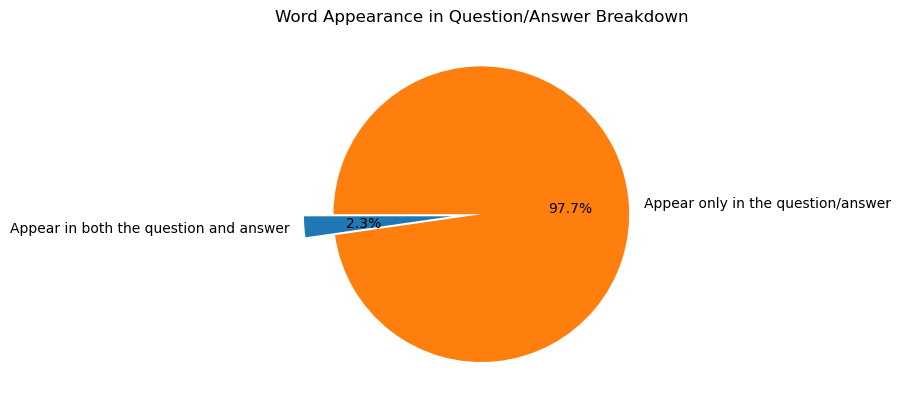

In [66]:
# Get the mean of the column
answer_in_question_perc = jeopardy['answer_in_question'].mean()*100

# Plot a pie chart
explode = (0.2, 0)
plt.pie([answer_in_question_perc, 100 - answer_in_question_perc], labels=["Appear in both the question and answer", "Appear only in the question/answer"], autopct='%1.1f%%', explode=explode, startangle=180)
plt.title("Word Appearance in Question/Answer Breakdown")
plt.show()

It seems that about 2% of the words in the answers appear in their questions as well. This number is quite small, so the odds that the question's wording will give enough information to get the answer right are too small for comfort.

### Recycled Questions <a name="recycled_questions"></a>

Maybe if the contestant will simply memorise past questions, they'll gain an edge on other contestants. Let's see how often new questions are repeats of older ones, by counting the terms that appear more than once in the dataset.

In [67]:
def get_question_overlap(row, seen):
    # Count all words in the question that have already appeared 
    match_count = sum([1 for word in row['split_question'] if word in seen])

    # Add all words to our repository
    seen.update(row['split_question'])

    # Get the proportion of the words in the question that have been seen before
    if len(row['split_question']):
        return match_count / len(row['split_question'])
    
    return 0

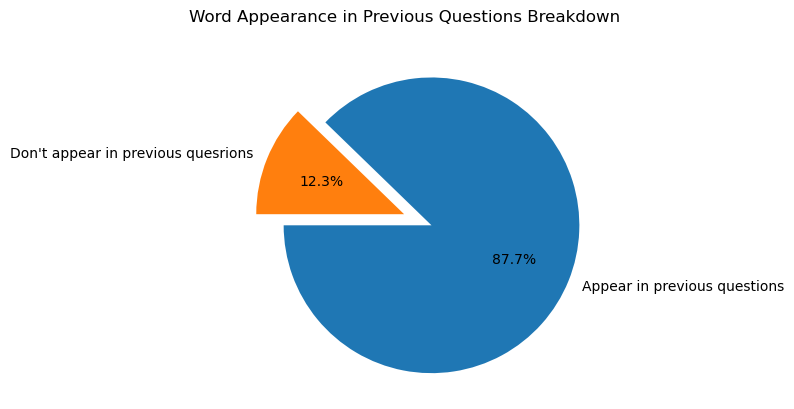

In [69]:
jeopardy.sort_values(by='Clean Air Date', inplace=True)

terms_used = set()

jeopardy['question_overlap'] = jeopardy.apply(get_question_overlap, axis=1, seen=terms_used)

# Get the mean of the column
overlap_perc = jeopardy['question_overlap'].mean()*100

# Plot a pie chart
explode = (0.2, 0)
plt.pie([overlap_perc, 100 - overlap_perc], labels=["Appear in previous questions", "Don't appear in previous quesrions"], autopct='%1.1f%%', explode=explode, startangle=180)
plt.title("Word Appearance in Previous Questions Breakdown")
plt.show()

So about 88% of the terms in newer questions appeared in older questions. It's promising, but since we're looking at single words, not complete phrases, it requires more investigating.

### Low Value vs. High Value Questions <a name="low_v_high_value_questions"></a>


One approach we can investigate is focusing study on high-value questions. Since the contestant's resources are limited, it makes sense to spend them on the questions that will be most lucrative for them.

To learn which terms correspond to high-value questions we can do a Chi-squared test. This will allow us to find the words with the biggest difference in usage between high and low values.

Before running the test, let's narrow down the questions to 2 categories:
* low-value: any row where `Value` is `800` or less
* high-value: any row where `Value` is greater than `800`

In [59]:
def low_high_value(row):
    return 1 if row['clean_value'] >= 800 else 0

In [60]:
jeopardy['high_value'] = jeopardy.apply(low_high_value, axis=1)

This function only uses column operations to get `high_count` and `low_count`, so it runs quite fast.

In [61]:
def get_word_low_and_high_count(word):
    questions_with_word = jeopardy['split_question'].map(set([word]).issubset)
    high_count = jeopardy[(questions_with_word) & (jeopardy['high_value'] == 1)].shape[0]
    low_count = jeopardy[(questions_with_word) & (jeopardy['high_value'] == 0)].shape[0]
    return word, high_count, low_count

We'll call `get_word_low_and_high_count` for each term in our `terms_used` set, to build a  term frequencies series.

For increased efficiency, we're creating a Pandas series from `terms_used` and using `apply` on it.

Even after removing the stopwords and http links, the `terms_used` set is still quite large (almost 86,000 terms), so the process takes a bit of time to run (it took slightly less than an hour to run on my laptop).

In [62]:
import time
start = time.time()
term_freqs = pd.Series(list(terms_used)).apply(get_word_low_and_high_count)
print(term_freqs)
end = time.time()

0           (unproduced, 1, 0)
1           (speakergov, 0, 1)
2          (skullshaped, 1, 1)
3           (digestion, 10, 5)
4        (strengthening, 1, 1)
                 ...          
85912        (ivyleague, 0, 1)
85913           (podium, 5, 3)
85914      (whitehaired, 1, 0)
85915          (insert, 9, 11)
85916     (narcissistic, 1, 2)
Length: 85917, dtype: object


In [63]:
print(f"Seconds to run: {int(end - start)}")

Seconds to run: 3116


Now that we've found the observed counts for all of the terms, we can compute the expected counts and the chi-squared value.
But first, to save on processing and memorizing time, let's look only at the 5,000 most common words. Later we'll whittle them down even further.

In [64]:
freqs = pd.DataFrame(list(term_freqs), columns=['term', 'high_count', 'low_count'])
freqs['total_count'] = freqs['high_count'] + freqs['low_count']
highest_term_freqs = freqs.sort_values(by='total_count', ascending=False).head(5000)

Now that we have our top 5,000 terms we can run a Chi squared test on them:

In [66]:
high_value_count = jeopardy['high_value'].value_counts()[1]
low_value_count = jeopardy['high_value'].value_counts()[0]

def calc_chi_squared(row):
    total_proportion = row['total_count'] / jeopardy.shape[0]
    expected_high = total_proportion * high_value_count
    expected_low = total_proportion * low_value_count
    chi_square, p_value = chisquare([row['high_count'], row['low_count']], [expected_high, expected_low])
    chi_squared = ((row['term'], chi_square, p_value, row['high_count'], row['low_count']))

    return chi_squared

In [67]:
chi_squared = pd.DataFrame(list(highest_term_freqs.apply(calc_chi_squared, axis=1)), columns=['term', 'chi_squared', 'p_value', 'high_count', 'low_count'])
chi_squared.head()

,term,chi_squared,p_value,high_count,low_count
0,called,14.718500,0.000125,2459,2935
1,country,0.042043,0.837537,2078,2738
2,became,0.047728,0.827065,1352,1778
3,played,7.476629,0.006250,1185,1741
4,president,2.365642,0.124033,1209,1698


To find the words that tend to be in the high-value questions we'll only take the ones with a `high_count` higher than their `low_count` and a p-value lower than 0.05 (which means this is a significant finding, and not just a random coincidence).

In [68]:
chi_squared = chi_squared[(chi_squared['p_value'] < 0.05) & (chi_squared['high_count'] > chi_squared['low_count'])]
chi_squared

,term,chi_squared,p_value,high_count,low_count
8,french,107.420043,3.601460e-25,1308,1143
19,author,93.375719,4.325244e-22,919,762
21,meaning,63.595300,1.527933e-15,821,727
32,reports,185.696134,2.765843e-42,765,464
40,german,76.174670,2.596510e-18,596,463
...,...,...,...,...,...
4960,definitely,4.301638,3.807568e-02,18,11
4975,pleasant,7.976135,4.739803e-03,20,9
4983,hunger,7.976135,4.739803e-03,20,9
4986,cosmic,5.998199,1.432049e-02,19,10


## Conclusion <a name="conclusion"></a>

In this project we reviewed historical questions used in the Jeopardy game show, to try and see if a future contestant can use that data to focus their studies and gain an advantage.
We wanted to answer two questions:
* How frequently do terms in the question appear in the answer?
* Which terms have already been used in questions?

We found that about 2% of the terms in the questions also appear in the answer. That proportion is quite small to be helpful in preparing for the game, so we moved on to the next question.

We found that about 88% of the terms made several appearances throughout the gameshow, which prompted us to investigate further.
On further investigation, we extracted 537 terms that appeared most times for higher-value questions (over $800).
By focusing their time on studying these terms a contestant may have a higher likelihood of being able to answer the high-value questions.
They can, of course, filter the list down, by taking the top 200, 100 or even terms, and focus only on those. It's up to how much time, energy and brain capacity they have.

## Next Steps <a name="next_steps"></a>

* Correct typos. During the analysis we noticed that several of the terms in the dataset have typos. That can affect the analysis, and it may be worthwhile to run an automatic spelling checker before doing another analysis
* Single words don't capture the whole context of the question well. Instead of breaking the question to single words we can try using the power of LLMs to get a better understanding of the question's nature
* Use the `category` data. We can run several analyses on the categories of the questions, such as which categories tend to crop up in most episodes, which ones have the most repeated questions, etc.